In [1]:
from pathlib import Path
import pytorch_lightning as pl
import torch
import json
import os
import iobes
import pandas as pd
import re

from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pytorch_lightning import Trainer

from nltk.data import load
from nltk.tokenize import TreebankWordTokenizer

from transformers import BertForTokenClassification, AdamW, get_linear_schedule_with_warmup, logging
from tokenizers import BertWordPieceTokenizer
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

C:\Users\schir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [48]:

class RuNNEPreprocessor:
    def __init__(self, DATASET_PATH=Path("public_dat")):
        # self.dev = pd.read_json(f'{DATASET_PATH}/dev.jsonl', lines=True)
        # self.test = pd.read_json(f'{DATASET_PATH}/test.jsonl', lines=True)
        self.train = pd.read_json(DATASET_PATH / 'train.jsonl', lines=True)
        self.train['sentences'] = self.train.sentences.apply(lambda x: x.replace('«', '\"').replace('»', '\"'))

    def get_pos(self, sent: str, tokens: list[str]):
        pos = []
        start = 0
        for token in tokens:
            t_start = sent.find(token, start)
            if t_start != -1:
                pos.append((t_start, t_start + len(token) - 1))
                start = t_start + len(token)
        return pos
    
    def label_preprocessing(self):
        self.all_labels = set(self.train.ners.apply(lambda x: [y[2] for y in x]).sum())
        self.dual_labels = {'B-' + x for x in self.all_labels}.union({'I-' + x for x in self.all_labels})
        print(len(self.all_labels), self.all_labels)
        self.label2id = {v: k for k, v in enumerate(self.dual_labels)}
        self.id2label = {k: v for k, v in enumerate(self.dual_labels)}
    
    def tokenizer_transform(self):

        tokenizer = TreebankWordTokenizer()
        punctuation_patterns = [
            (re.compile(r'(\w)\.'), '\1 \.'),
            (re.compile(r'([^\s])(-|\|)([^\s])'), r'\1 \2 \3'),
            (re.compile(r'(\d+):(\d)+'), r'\1 : \2')
        ]

        for pattern, replacement in punctuation_patterns:
            if (pattern, replacement) not in tokenizer.PUNCTUATION:
                tokenizer.PUNCTUATION.append((pattern, replacement))

        def tokenize_(sentence, tokenizer):
            tokens_ = tokenizer.tokenize(sentence)
            spans_ = tokenizer.span_tokenize(sentence)

            tokens_with_spans = [(token, start, end - 1) for token, (start, end) in zip(tokens_, spans_)]

            return tokens_with_spans
        def get_spans(sentence, tokenizer):
            spans_ = tokenizer.span_tokenize(sentence)
            spans = [(start, end - 1) for start, end in spans_]
            return spans
        
        self.train['tokens'] = self.train.sentences.apply(lambda x: tokenize_(x, tokenizer))
        self.train['spans'] = self.train.sentences.apply(lambda x: get_spans(x, tokenizer))

    def map_ner(self, ner: tuple[int, int, str], spans: list[tuple[int, int]]):
        def left_binary_search(spans, ner):
            left, right = 0, len(spans)
            while right - left > 1:
                mid = (right + left) >> 1
                if spans[mid][0] <= ner[0]:
                    left = mid
                else:
                    right = mid

            return left
        
        def right_binary_search(spans, ner):
            left, right = -1, len(spans) -1
            while right - left > 1:
                mid = (right + left) >> 1
                if spans[mid][1] >= ner[1]:
                    right = mid
                else:
                    left = mid
            return right

        left_span = left_binary_search(spans, ner)
        right_span = right_binary_search(spans, ner)
        
        assert left_span <= right_span, (left_span, spans[left_span], right_span, spans[right_span], ner)
        return (left_span, right_span), (spans[left_span][0], spans[right_span][1])
        
    def span_ners(self):
        self.train['span_ners'] = self.train.apply(lambda x: [self.map_ner(y, x['spans']) for y in x['ners']], axis=1)

    def create_labels(self):
        def create_labels_(ners, spans):
            labels = [[0 for _ in self.dual_labels] for _ in spans]
            for n in ners:
                (i, j), _ = self.map_ner(n, spans)
                labels[i][self.label2id['B-' + n[2]]] = 1
                for k in range(i + 1, j + 1):
                    labels[k][self.label2id['I-' + n[2]]] = 1
            return labels

        def label_tokens(row):
            return create_labels_(row.ners, row.spans)

        self.train['labels'] = self.train.apply(label_tokens, axis=1)


    def preprocess_data(self):
        self.label_preprocessing()
        self.tokenizer_transform()
        self.span_ners()
        self.create_labels()
        return self.train

# Пример использования
preprocessor = RuNNEPreprocessor()
train_dataset = preprocessor.preprocess_data()
train_dataset

29 {'NATIONALITY', 'DISEASE', 'ORDINAL', 'PRODUCT', 'TIME', 'WORK_OF_ART', 'LANGUAGE', 'EVENT', 'AWARD', 'CITY', 'LOCATION', 'ORGANIZATION', 'MONEY', 'RELIGION', 'PERSON', 'COUNTRY', 'STATE_OR_PROVINCE', 'CRIME', 'DATE', 'PROFESSION', 'DISTRICT', 'PENALTY', 'AGE', 'LAW', 'PERCENT', 'FAMILY', 'IDEOLOGY', 'FACILITY', 'NUMBER'}


,ners,sentences,id,tokens,spans,span_ners,labels
0,"[[0, 5, CITY], [16, 23, PERSON], [34, 41, PERS...",Бостон взорвали Тамерлан и Джохар Царнаевы из ...,0,"[(Бостон, 0, 5), (взорвали, 7, 14), (Тамерлан,...","[(0, 5), (7, 14), (16, 23), (25, 25), (27, 32)...","[((0, 0), (0, 5)), ((2, 2), (16, 23)), ((5, 5)...","[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,"[[21, 28, PROFESSION], [53, 67, ORGANIZATION],...",Умер избитый до комы гитарист и сооснователь г...,1,"[(Умер, 0, 3), (избитый, 5, 11), (до, 13, 14),...","[(0, 3), (5, 11), (13, 14), (16, 19), (21, 28)...","[((4, 4), (21, 28)), ((9, 10), (53, 67)), ((16...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[[0, 4, PERSON], [37, 42, COUNTRY], [47, 76, O...",Путин подписал распоряжение о выходе России из...,2,"[(Путин, 0, 4), (подписал, 6, 13), (распоряжен...","[(0, 4), (6, 13), (15, 26), (28, 28), (30, 35)...","[((0, 0), (0, 4)), ((5, 5), (37, 42)), ((7, 9)...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
3,"[[0, 11, PERSON], [36, 47, PROFESSION], [49, 6...",Бенедикт XVI носил кардиостимулятор\nПапа Римс...,3,"[(Бенедикт, 0, 7), (XVI, 9, 11), (носил, 13, 1...","[(0, 7), (9, 11), (13, 17), (19, 34), (36, 39)...","[((0, 1), (0, 11)), ((4, 5), (36, 47)), ((6, 7...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
4,"[[0, 4, PERSON], [17, 29, ORGANIZATION], [48, ...",Обама назначит в Верховный суд латиноамериканк...,4,"[(Обама, 0, 4), (назначит, 6, 13), (в, 15, 15)...","[(0, 4), (6, 13), (15, 15), (17, 25), (27, 29)...","[((0, 0), (0, 4)), ((3, 4), (17, 29)), ((6, 6)...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
...,...,...,...,...,...,...,...
514,"[[42, 46, COUNTRY], [82, 87, COUNTRY], [104, 1...",Глава Малайзии: мы не хотим противостоять Кита...,514,"[(Глава, 0, 4), (Малайзии, 6, 13), (:, 14, 14)...","[(0, 4), (6, 13), (14, 14), (16, 17), (19, 20)...","[((7, 7), (42, 46)), ((13, 13), (82, 87)), ((1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
515,"[[1, 4, PRODUCT], [31, 33, FACILITY], [35, 44,...","""Союз"" впервые пристыковался к МКС за 6 часов\...",515,"[(``, 0, 0), (Союз, 1, 4), ('', 5, 5), (впервы...","[(0, 0), (1, 4), (5, 5), (7, 13), (15, 27), (2...","[((1, 1), (1, 4)), ((6, 6), (31, 33)), ((7, 9)...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
516,"[[0, 4, PERSON], [8, 12, PERSON], [45, 52, AGE...",Трамп и Путин сделали совместное заявление к 7...,516,"[(Трамп, 0, 4), (и, 6, 6), (Путин, 8, 12), (сд...","[(0, 4), (6, 6), (8, 12), (14, 20), (22, 31), ...","[((0, 0), (0, 4)), ((2, 2), (8, 12)), ((7, 9),...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,..."
517,"[[0, 9, NATIONALITY], [58, 72, PERSON], [101, ...",Российский магнат устроил самую дорогую свадьб...,517,"[(Российский, 0, 9), (магнат, 11, 16), (устрои...","[(0, 9), (11, 16), (18, 24), (26, 30), (32, 38...","[((0, 0), (0, 9)), ((8, 9), (58, 72)), ((12, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


In [3]:
all_labels = {'NATIONALITY', 'DISEASE', 'ORDINAL', 'PRODUCT', 'TIME', 'WORK_OF_ART', 'LANGUAGE', 'EVENT', 'AWARD', 'CITY', 'LOCATION', 'ORGANIZATION', 'MONEY', 'RELIGION', 'PERSON', 'COUNTRY', 'STATE_OR_PROVINCE', 'CRIME', 'DATE', 'PROFESSION', 'DISTRICT', 'PENALTY', 'AGE', 'LAW', 'PERCENT', 'FAMILY', 'IDEOLOGY', 'FACILITY', 'NUMBER'}

In [4]:
# Раздваиваем сущности
dual_labels = {'B-' + x for x in all_labels}.union({'I-' + x for x in all_labels})

# Словарики чтобы превращать тэги в цифры
label2id = {
    v: k
    for k, v in enumerate(dual_labels)
}
id2label = {
    k: v
    for k, v in enumerate(dual_labels)
}

In [38]:
%pip install navec

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\schir\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [41]:
if not os.path.exists('navec_hudlit_v1_12B_500K_300d_100q.tar'):
    !wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [5]:
from navec import Navec

embeddings = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

Pair = tuple[int, int]

class NERDataset(Dataset):
    def __init__(
        self,
        batch_tokens: list[list[tuple[int, int, str]]],
        batch_labels: list[list[int]],
    ):
        self._tokens = sum(batch_tokens, [])
        self._ners = sum(batch_labels, [])
        
    def __len__(self):
        return len(self._tokens)

    def __getitem__(self, index):
        return self._tokens[index], self._ners[index]
    

def vectorize(word: str) -> torch.Tensor:
    if word not in embeddings:
        # If not found, return sum of embeddings of all characters
        vec = torch.stack([
            torch.as_tensor(embeddings.get(x, embeddings['<unk>']))
            for x in word
        ], dim=0).mean(dim=0)
    else:
        vec = embeddings.get(word)
    return torch.as_tensor(vec)
        
class NERLoader(DataLoader):

    def __init__(self, dataset: NERDataset, *args, **kwargs):
        if not isinstance(dataset, NERDataset):
            raise ValueError('NERLoader only supports NERDataset')
        
        def collate(batch):
            tokens, ners = zip(*batch)
            inputs = torch.stack([
                vectorize(x[0])
                for x in tokens
            ])

            # (batch, tokens)
            # (batch, cls)
            return inputs, torch.tensor(ners, dtype=torch.long)
        
        super().__init__(dataset, *args, **kwargs, collate_fn=collate)

In [52]:
train = NERDataset(train_dataset.tokens.to_list(), train_dataset.labels.to_list())
train_loader = NERLoader(train, batch_size=32)

In [54]:
train[0]

(('Бостон', 0, 5),
 [0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

In [6]:
import torch.nn as nn

class SimpleGPU(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.gru = nn.GRU(300, 512, 16, batch_first=True)
        self.class_head = nn.Sequential(
            nn.GELU(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 58)
        )
        
    def forward(self, input_sequence: torch.Tensor):
        output, _ = self.gru(input_sequence)
        return self.class_head(output)

In [7]:
model = SimpleGPU()

In [57]:
losses = []
crit = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model.train()
model = model.to(device)
for spans, labels in train_loader:
    spans = spans.to(device)
    labels = labels.to(device)
    outputs = model(spans)
    
    loss = crit(outputs, labels.to(torch.float))
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    

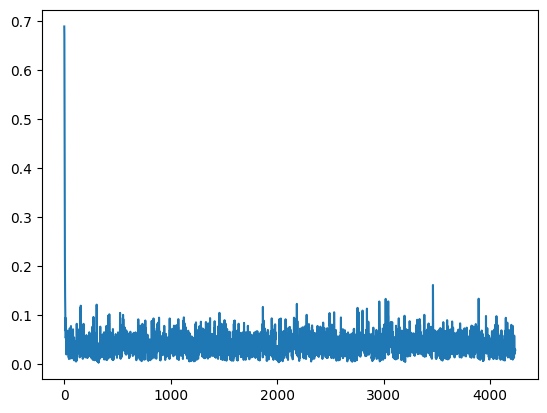

In [58]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [70]:
torch.save(model.state_dict(), 'model_checkpoint/model_SimpleGPU.pt')